An overview of the German electricity prices
=======

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install -q statsmodels

data_file_path = 'Germany.csv'
dataframe = pd.read_csv(data_file_path)
dataframe['Datetime (UTC)'] = pd.to_datetime(dataframe['Datetime (UTC)']) # Wir konvertieren das datum in ein Datenformat
dataframe = dataframe.sort_values(by='Datetime (UTC)')
dataframe.index = pd.to_datetime(dataframe['Datetime (UTC)'])

## Initial observations
The SMARD Data for Germany contains hourly prices ranging from the first of January 2015 to the first of April, making up a total of 81'073 data points. Inspecting the price given in €/MWhe, various interesting observations can be made:
- Negative electricity prices exist. This occured a total of 1606 times, with the price being exactly 0€ 65 times. 
- The lowest recorded price in the data set was -500€, occuring at 2022-08-23 20:00:00. The second lowest price with -399€ was achieved the same day. These are stark outliers, with only 13 entries below the -100€ mark. The sum being exactly 500.00€ in particular stands out as peculiar.
- The highest recorded price in the data set was 1047.11€, occurring at  2023-07-02 14:00:00. In total, only 5 entries surpass the 900€ mark, all of them past 2023. 

In [86]:
print(dataframe.sort_values(by=['Price (EUR/MWhe)']))

                     Country ISO3 Code      Datetime (UTC)  \
Datetime (UTC)                                               
2023-07-02 12:00:00  Germany       DEU 2023-07-02 12:00:00   
2023-07-02 13:00:00  Germany       DEU 2023-07-02 13:00:00   
2023-07-02 11:00:00  Germany       DEU 2023-07-02 11:00:00   
2023-07-02 10:00:00  Germany       DEU 2023-07-02 10:00:00   
2023-01-16 04:00:00  Germany       DEU 2023-01-16 04:00:00   
...                      ...       ...                 ...   
2022-09-19 18:00:00  Germany       DEU 2022-09-19 18:00:00   
2022-08-26 18:00:00  Germany       DEU 2022-08-26 18:00:00   
2022-08-29 20:00:00  Germany       DEU 2022-08-29 20:00:00   
2022-08-24 18:00:00  Germany       DEU 2022-08-24 18:00:00   
2022-08-23 18:00:00  Germany       DEU 2022-08-23 18:00:00   

                        Datetime (Local)  Price (EUR/MWhe)  
Datetime (UTC)                                              
2023-07-02 12:00:00  2023-07-02 14:00:00           -500.00  
2023-07-02

# Explaining negative values
Negative wholesale electricity prices are a phenomenon that arises when high and inflexible electricity generation, frequently from renewable sources such as wind and solar, coincides with low demand, particularly during periods of low consumption such as holidays. During these times, producers are remunerated for offloading excess electricity, which results in negative prices. This typically occurs when renewable generation exceeds demand, as evidenced by the case of Easter Monday 2019 in Germany, where the country's entire electricity needs were met by renewable energy production.
Further information can be found on the smard website itself.
https://www.smard.de/page/en/wiki-article/5884/105426

## Initial Plotting
An initial plotting of the entire data immediatly draws attention to the uniformity of the graph prior to the second half of 2021 compared to the much larger variance in the latter part of the diagram. However, not much else stands out to the uninformed eye.

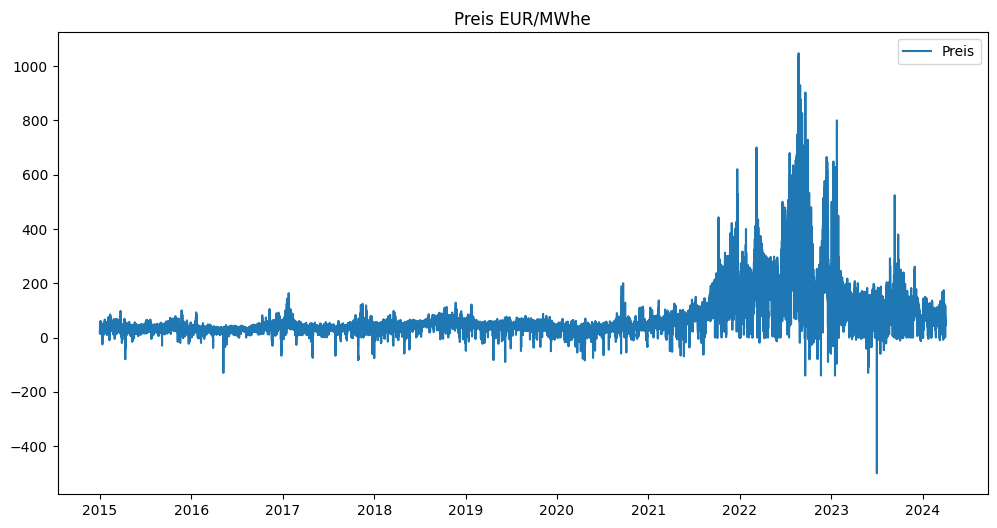

In [87]:
plt.figure(figsize=(12,6))
plt.plot(dataframe['Datetime (UTC)'], dataframe['Price (EUR/MWhe)'], label='Preis')
plt.legend()
plt.title('Preis EUR/MWhe')
plt.show()


# Smaller Trends with seasonal decompose
However, at this scale, the data might not be very indicative. To gain further insight, a simple decomposition is done on the span of the last four weeks. 
Here, the seasonal window clearly shows each day, with 28 distinct repeating patterns, showcasing the individual days and indicating a strong dailiy cycle. The trend window on the other hand, indicates a lowered prices on weekends. 

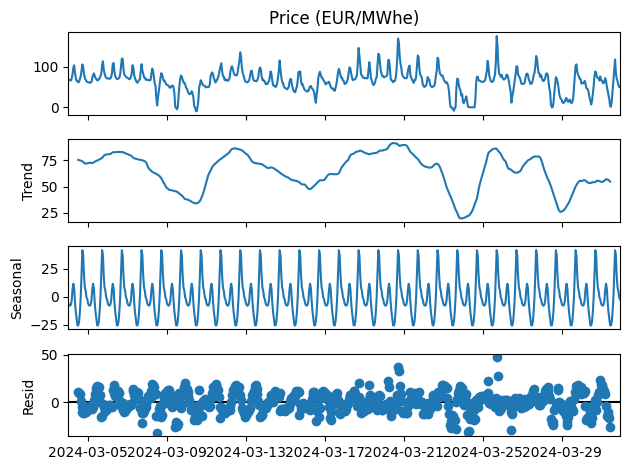

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = dataframe['Price (EUR/MWhe)']
#24 *7 * 4 = 672 
result = seasonal_decompose(series[-672:], model='additive')
result.plot()
plt.show()


# Plotting these trends

First, let's take a look at the daily trend. 

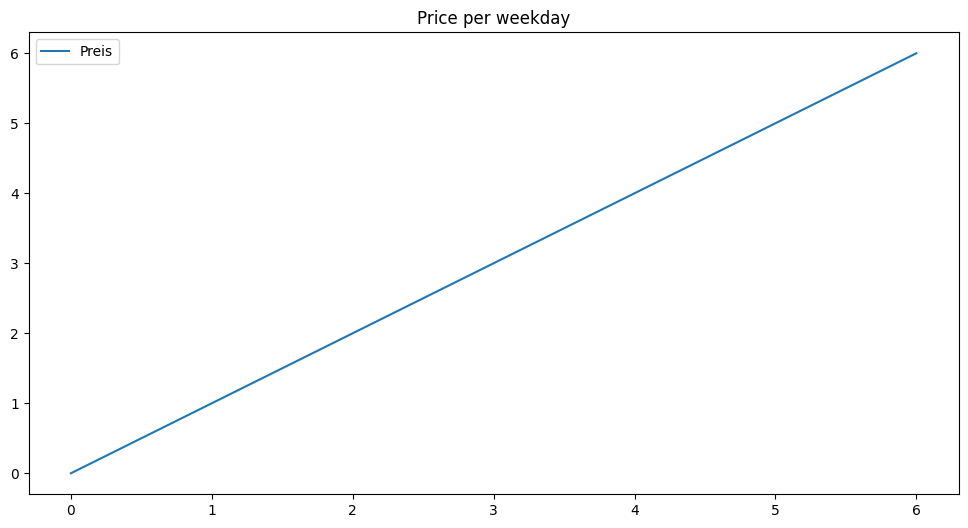

KeyError: 'Datetime (UTC)'

In [141]:
dataframe.set_index('Datetime (UTC)')
#dataframe.resample('D').sum()
dataframe['Month'] = dataframe['Datetime (UTC)'].dt.month
weekday_mean_frame = dataframe.groupby(dataframe["Datetime (UTC)"].dt.weekday)['Price (EUR/MWhe)'].mean()

weekday_mean_frame.head
plt.figure(figsize=(12,6))
plt.plot(weekday_mean_frame.index,label='Preis')
plt.legend()
plt.title('Price per weekday')
plt.show()
weekday_mean_frame["Datetime (UTC)"]